<a href="https://colab.research.google.com/github/vinismachadoo/aviacao_civil_brasil/blob/main/controle_estatistico_voos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download -d ramirobentes/flights-in-brazil

 83% 66.0M/79.3M [00:00<00:00, 52.7MB/s]
100% 79.3M/79.3M [00:01<00:00, 81.9MB/s]


In [4]:
!unzip flights-in-brazil.zip

Archive:  flights-in-brazil.zip
  inflating: BrFlights2.csv          
  inflating: BrFlights2/BrFlights2.csv  


In [5]:
!pip install geopandas --quiet

     |████████████████████████████████| 972kB 7.7MB/s 
     |████████████████████████████████| 6.5MB 12.9MB/s 
     |████████████████████████████████| 14.8MB 337kB/s 


In [6]:
import pandas as pd
pd.options.display.max_columns=100

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import geopandas as gpd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
mapa_brasil = gpd.read_file('https://raw.githubusercontent.com/vinismachadoo/aviacao_civil_brasil/main/uf_brasil.geojson')

In [8]:
voos_brasil = pd.read_csv('BrFlights2.csv', encoding='ISO-8859-1')

In [9]:
#Escolhemos trabalhar apenas com voos regionais e nacionais, portanto deletando quaisquer origem ou destino internacional
voos_brasil = voos_brasil[~voos_brasil['Codigo.Tipo.Linha'].isin(['Internacional'])]

In [10]:
voos_brasil.shape

(2221559, 21)

In [11]:
voos_brasil.head()

,Voos,Companhia.Aerea,Codigo.Tipo.Linha,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Cidade.Origem,Estado.Origem,Pais.Origem,Aeroporto.Destino,Cidade.Destino,Estado.Destino,Pais.Destino,LongDest,LatDest,LongOrig,LatOrig
2659,AZU - 2400,AZUL,Regional,2016-01-18T08:25:00Z,NaN,2016-01-18T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2660,AZU - 2400,AZUL,Regional,2016-01-26T08:25:00Z,NaN,2016-01-26T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2661,AZU - 2400,AZUL,Regional,2016-01-22T08:25:00Z,NaN,2016-01-22T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2662,AZU - 2400,AZUL,Regional,2016-01-16T08:25:00Z,NaN,2016-01-16T09:32:00Z,NaN,Cancelado,CANCELAMENTO - AEROPORTO DESTINO ABAIXO LIMITES,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2663,AZU - 2400,AZUL,Regional,2016-01-01T08:25:00Z,NaN,2016-01-01T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553


In [12]:
voos_brasil['Aeroporto.Origem'].replace({'Guarulhos - Governador Andre Franco Montoro':'Garulhos',
                                          'Aeroporto Internacional Do Rio De Janeiro/Galeao':'Galeao'}, inplace=True)

In [13]:
#Acertando as colunas com dia e hora para formato datetime
voos_brasil['Partida.Prevista'] = pd.to_datetime(voos_brasil['Partida.Prevista'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Partida.Real'] = pd.to_datetime(voos_brasil['Partida.Real'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Chegada.Prevista'] = pd.to_datetime(voos_brasil['Chegada.Prevista'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Chegada.Real'] = pd.to_datetime(voos_brasil['Chegada.Real'], format="%Y-%m-%dT%H:%M:%SZ")

In [14]:
#Novas colunas apenas com data
voos_brasil['Partida.Prevista.Data'] = voos_brasil['Partida.Prevista'].dt.date
voos_brasil['Partida.Real.Data'] = voos_brasil['Partida.Real'].dt.date
voos_brasil['Chegada.Prevista.Data'] = voos_brasil['Chegada.Prevista'].dt.date
voos_brasil['Chegada.Real.Data'] = voos_brasil['Chegada.Real'].dt.date

In [15]:
f"Primeiro dia do dataset: {voos_brasil['Partida.Prevista.Data'].min()}. Ultimo dia do dataset: {voos_brasil['Partida.Prevista.Data'].max()}"

'Primeiro dia do dataset: 2015-01-01. Ultimo dia do dataset: 2017-08-01'

In [16]:
#Criando uma série pra cada ano pra poder plotar o gráfico sobreposto por ano
voos_brasil_2015 = voos_brasil[voos_brasil['Partida.Prevista'].dt.year == 2015]
voos_brasil_2015['Mes.Dia'] = voos_brasil_2015['Partida.Prevista'].dt.month.astype(str) + '-' + voos_brasil_2015['Partida.Prevista'].dt.day.astype(str)
voos_brasil_2016 = voos_brasil[voos_brasil['Partida.Prevista'].dt.year == 2016]
voos_brasil_2016['Mes.Dia'] = voos_brasil_2016['Partida.Prevista'].dt.month.astype(str) + '-' + voos_brasil_2016['Partida.Prevista'].dt.day.astype(str)
voos_brasil_2017 = voos_brasil[voos_brasil['Partida.Prevista'].dt.year == 2017]
voos_brasil_2017['Mes.Dia'] = voos_brasil_2017['Partida.Prevista'].dt.month.astype(str) + '-' + voos_brasil_2017['Partida.Prevista'].dt.day.astype(str)

In [17]:
print('Registros em 2015:', voos_brasil_2015.shape[0])
print('Registros em 2016:', voos_brasil_2016.shape[0])
print('Registros em 2017 (até agosto):', voos_brasil_2017.shape[0])

Registros em 2015: 951170
Registros em 2016: 816213
Registros em 2017 (até agosto): 454176


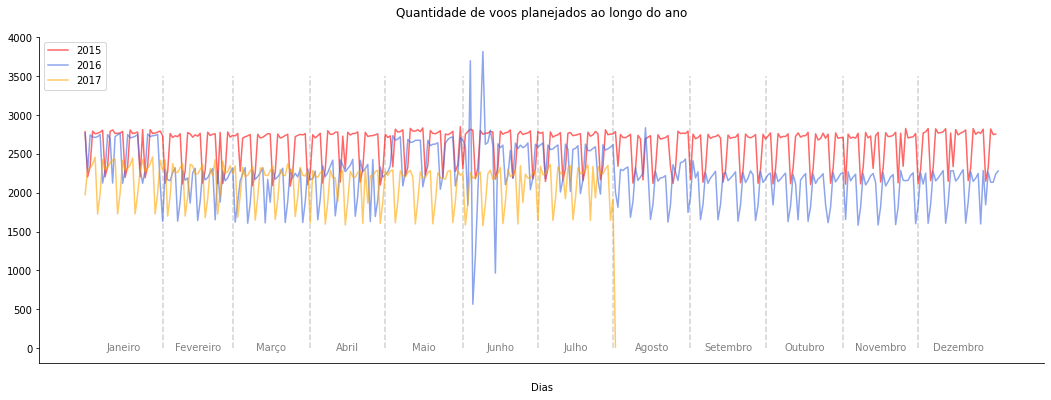

In [18]:
fig,ax = plt.subplots(figsize=(18,6))
voos_brasil_2015.groupby('Mes.Dia')['Voos'].count().plot(label='2015', color='red', alpha=0.6)
voos_brasil_2016.groupby('Mes.Dia')['Voos'].count().plot(label='2016', color='royalblue', alpha=0.6)
voos_brasil_2017.groupby('Mes.Dia')['Voos'].count().plot(label='2017', color='orange', alpha=0.6)

plt.title('Quantidade de voos planejados ao longo do ano', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Dias', labelpad=20)

meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro']
primeiro_dia_mes = [0,31,59,90,120,151,181,211,242,272,303,333]
for i in range(11):
  ax.vlines(x=primeiro_dia_mes[i+1],ymin=0,ymax=3500, color='lightgray', linestyle='--')
  ax.text((primeiro_dia_mes[i]+primeiro_dia_mes[i+1])/2, 10, meses[i], ha='center', va='center', color='gray')
ax.text(349,10,"Dezembro", ha='center', va='center', color='gray')
plt.xticks([])

plt.legend(loc='upper left')
plt.show()

In [19]:
#Novas colunas com o dia da semana do voo
voos_brasil['Partida.Prevista.Dia.Semana'] = voos_brasil['Partida.Prevista'].dt.day_name()
voos_brasil['Partida.Real.Dia.Semana'] = voos_brasil['Partida.Real'].dt.day_name()
voos_brasil['Chegada.Prevista.Dia.Semana'] = voos_brasil['Chegada.Prevista'].dt.day_name()
voos_brasil['Chegada.Real.Dia.Semana'] = voos_brasil['Chegada.Real'].dt.day_name()

In [20]:
#Listas ordenadas para melhor visualização
dias_da_semana_en = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dias_da_semana_pt = ['Segunda','Terça','Quarta','Quinta','Sexta','Sábado','Domingo']

In [21]:
#Colocandos os dias sa semana para portugês
voos_brasil['Partida.Prevista.Dia.Semana'].replace({en: pt for en,pt in zip(dias_da_semana_en, dias_da_semana_pt)}, inplace=True)
voos_brasil['Partida.Real.Dia.Semana'].replace({en: pt for en,pt in zip(dias_da_semana_en, dias_da_semana_pt)}, inplace=True)
voos_brasil['Chegada.Prevista.Dia.Semana'].replace({en: pt for en,pt in zip(dias_da_semana_en, dias_da_semana_pt)}, inplace=True)
voos_brasil['Chegada.Real.Dia.Semana'].replace({en: pt for en,pt in zip(dias_da_semana_en, dias_da_semana_pt)}, inplace=True)

In [22]:
#Transformando em categorias pra ficar sempre em ordem do dias da semana
voos_brasil['Partida.Prevista.Dia.Semana'] = pd.Categorical(voos_brasil['Partida.Prevista.Dia.Semana'], categories=dias_da_semana_pt)
voos_brasil['Partida.Real.Dia.Semana'] = pd.Categorical(voos_brasil['Partida.Real.Dia.Semana'], categories=dias_da_semana_pt) 
voos_brasil['Chegada.Prevista.Dia.Semana'] = pd.Categorical(voos_brasil['Chegada.Prevista.Dia.Semana'], categories=dias_da_semana_pt) 
voos_brasil['Chegada.Real.Dia.Semana'] = pd.Categorical(voos_brasil['Chegada.Real.Dia.Semana'], categories=dias_da_semana_pt) 

In [23]:
#Dissecando o status 'Realizado' em 3: 'Atrasado', 'Adiantado' ou 'Em ponto'
voos_brasil.loc[voos_brasil['Partida.Real'] > voos_brasil['Partida.Prevista'], 'Situacao.Voo'] = 'Atrasado'
voos_brasil.loc[voos_brasil['Partida.Real'] < voos_brasil['Partida.Prevista'], 'Situacao.Voo'] = 'Adiantado'
voos_brasil['Situacao.Voo'].replace({'Realizado': 'Em ponto'}, inplace=True)

In [24]:
voos_brasil['Situacao.Voo'].value_counts()

Em ponto     1284055
Adiantado     351045
Atrasado      311179
Cancelado     275280
Name: Situacao.Voo, dtype: int64

In [25]:
#Agrupando por dia da semana e status do voo
situacao_por_dia_semana = voos_brasil.groupby(['Partida.Prevista.Dia.Semana'])['Situacao.Voo'].value_counts(normalize=True).unstack()
situacao_por_dia_semana

Situacao.Voo,Adiantado,Atrasado,Cancelado,Em ponto
Partida.Prevista.Dia.Semana,,,,
Segunda,0.157908,0.147616,0.115103,0.579373
Terça,0.163681,0.129267,0.131024,0.576028
Quarta,0.161602,0.135949,0.128313,0.574136
Quinta,0.153001,0.157134,0.119829,0.570036
Sexta,0.146748,0.165807,0.118618,0.568827
Sábado,0.157600,0.115366,0.140218,0.586817
Domingo,0.167482,0.118840,0.117664,0.596013


In [26]:
#Agrupando por dia da semana e status do voo
situacao_por_dia_semana = voos_brasil.groupby(['Partida.Prevista.Dia.Semana'])['Situacao.Voo'].value_counts().unstack()
situacao_por_dia_semana

Situacao.Voo,Adiantado,Atrasado,Cancelado,Em ponto
Partida.Prevista.Dia.Semana,,,,
Segunda,54037,50515,39389,198265
Terça,53950,42607,43186,189861
Quarta,53753,45220,42680,190972
Quinta,51608,53002,40419,192276
Sexta,50503,57062,40822,195760
Sábado,40212,29436,35777,149728
Domingo,46982,33337,33007,167193


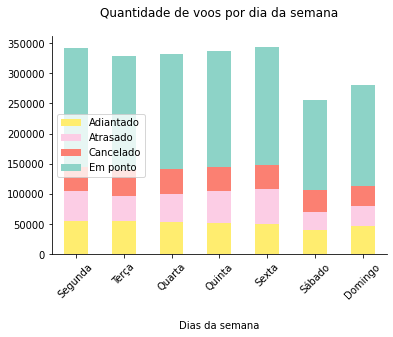

In [27]:
situacao_por_dia_semana.plot(kind='bar', stacked=True, colormap='Set3_r')
plt.title('Quantidade de voos por dia da semana', pad=20, fontsize=12, color='black')
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dias da semana', labelpad=20)
plt.legend(loc='center left')
plt.show()

In [28]:
#Renomeando AVIANCA BRASIL para AVIANCA
voos_brasil['Companhia.Aerea'].replace({'AVIANCA BRASIL':'AVIANCA'}, inplace=True)

In [29]:
#Quantidade de voos por companhia dividido por status do voo
situacao_por_companhia = voos_brasil.groupby(['Companhia.Aerea'])['Situacao.Voo'].value_counts().unstack()
situacao_por_companhia = situacao_por_companhia.assign(tmp=situacao_por_companhia.sum(axis=1)).sort_values('tmp', ascending=True).drop('tmp', 1)

In [30]:
situacao_por_companhia

Situacao.Voo,Adiantado,Atrasado,Cancelado,Em ponto
Companhia.Aerea,,,,
TRIP,NaN,NaN,NaN,10.0
TOTAL,599.0,697.0,16.0,3.0
FLYWAYS,30.0,151.0,473.0,1352.0
SETE,224.0,1693.0,511.0,5292.0
MAP LINHAS AEREAS,1940.0,1516.0,666.0,11553.0
PASSAREDO,2845.0,16537.0,12331.0,38723.0
AVIANCA,9267.0,31835.0,5995.0,136282.0
TAM,20222.0,68413.0,39589.0,357192.0
GOL,13265.0,86542.0,109850.0,510733.0


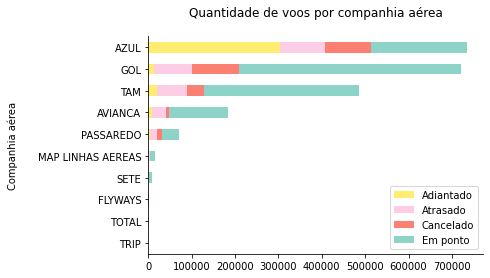

In [31]:
situacao_por_companhia.plot(kind='barh', stacked=True, colormap='Set3_r')
plt.title('Quantidade de voos por companhia aérea', pad=20, fontsize=12, color='black')
sns.despine()
plt.ylabel('Companhia aérea', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [32]:
#Usaremos só as 4 maiores companhias nacionais pois as demais não apresentam relevância
voos_brasil = voos_brasil[voos_brasil['Companhia.Aerea'].isin(['AZUL','GOL','TAM','AVIANCA'])]

In [33]:
#10 maiores aeroportos por quantidade absoluta de voo
situacao_por_aeroporto_origem = voos_brasil.groupby(['Aeroporto.Origem'])['Situacao.Voo'].value_counts().unstack()
situacao_por_aeroporto_origem = situacao_por_aeroporto_origem.assign(tmp=situacao_por_aeroporto_origem.sum(axis=1)).sort_values('tmp', ascending=True).drop('tmp', 1)

In [34]:
situacao_por_aeroporto_origem = situacao_por_aeroporto_origem[['Atrasado','Adiantado','Cancelado','Em ponto']]

In [35]:
situacao_por_aeroporto_origem.tail(10)

Situacao.Voo,Atrasado,Adiantado,Cancelado,Em ponto
Aeroporto.Origem,,,,
Salgado Filho,8614.0,15617.0,8424.0,47410.0
Afonso Pena,9143.0,16186.0,11929.0,44606.0
Deputado Luis Eduardo Magalhaes,10072.0,8637.0,10730.0,52876.0
Santos Dumont,14221.0,17527.0,11949.0,51733.0
Galeao,17195.0,6296.0,15097.0,84788.0
Tancredo Neves,19188.0,30600.0,17935.0,67744.0
Viracopos,24897.0,43833.0,23104.0,59147.0
Congonhas,24145.0,9048.0,8847.0,120261.0
Presidente Juscelino Kubitschek,26678.0,11038.0,20673.0,117588.0


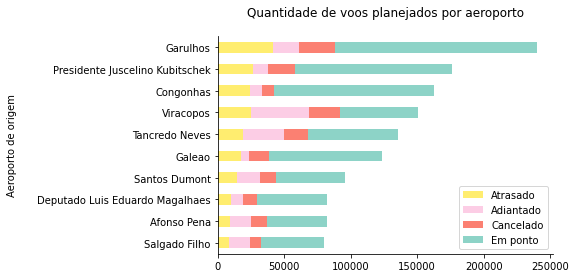

In [36]:
situacao_por_aeroporto_origem.tail(10).plot(kind='barh', stacked=True, colormap='Set3_r')
plt.title('Quantidade de voos planejados por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [37]:
#Ordenando os 10 maiores aeroportos por taxa de voos atrasados 
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem.tail(10).stack().groupby(level=0).apply(lambda x: 100*x / x.sum()).unstack()
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem_porcentagem.sort_values(by='Atrasado')

In [38]:
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem_porcentagem[['Atrasado','Adiantado','Cancelado','Em ponto']]
situacao_por_aeroporto_origem_porcentagem

Situacao.Voo,Atrasado,Adiantado,Cancelado,Em ponto
Aeroporto.Origem,,,,
Salgado Filho,10.758759,19.505402,10.521451,59.214388
Afonso Pena,11.168523,19.771817,14.571729,54.487931
Deputado Luis Eduardo Magalhaes,12.235923,10.492620,13.035291,64.236166
Galeao,13.937070,5.103099,12.236578,68.723252
Tancredo Neves,14.164335,22.588527,13.239387,50.007751
Congonhas,14.876680,5.574827,5.450983,74.097510
Santos Dumont,14.902022,18.366342,12.521220,54.210416
Presidente Juscelino Kubitschek,15.159936,6.272411,11.747558,66.820096
Viracopos,16.490154,29.032130,15.302588,39.175128


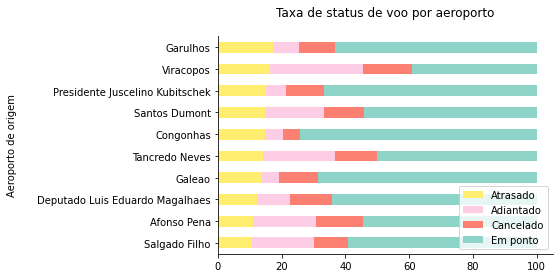

In [39]:
situacao_por_aeroporto_origem_porcentagem.plot(kind='barh', stacked=True, title='TOP 10 aeroportos por voos atrasados', colormap='Set3_r')
plt.title('Taxa de status de voo por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [40]:
#A partir deste resultado serão escolhidos 3 aeroportos com taxas de atraso parecidas para averiguar se os fatores que interferem on atraso são os mesmos
#Aeroportos escolhidos: Juscelino Kubitscheck (BSB, 15.16%), Santos Dumont (SDU, 14.90%) e Congonhas (CGH, 14.88%)

In [41]:
#filtrando apenas os voos com atrasos positivos
voos_brasil_atrasados = voos_brasil[voos_brasil['Situacao.Voo'].isin(['Atrasado'])]

In [42]:
voos_brasil_atrasados['Partida.Atraso'] = voos_brasil_atrasados['Partida.Real'] - voos_brasil_atrasados['Partida.Prevista']
voos_brasil_atrasados['Partida.Atraso'] = voos_brasil_atrasados['Partida.Atraso'].dt.seconds/60
voos_brasil_atrasados = voos_brasil_atrasados[voos_brasil_atrasados['Partida.Atraso'] > 0]

In [43]:
#Total de voos atrasados no Brasil
voos_brasil_atrasados.shape

(290516, 30)

In [44]:
#Selecionando os 3 aeroportos escolhidos
aeroportos_interesse = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'].isin(['Presidente Juscelino Kubitschek', 'Santos Dumont', 'Congonhas'])]
aeroportos_interesse.shape

(65037, 30)

In [45]:
aeroportos_interesse['Aeroporto.Origem'].value_counts()

Presidente Juscelino Kubitschek    26676
Congonhas                          24143
Santos Dumont                      14218
Name: Aeroporto.Origem, dtype: int64

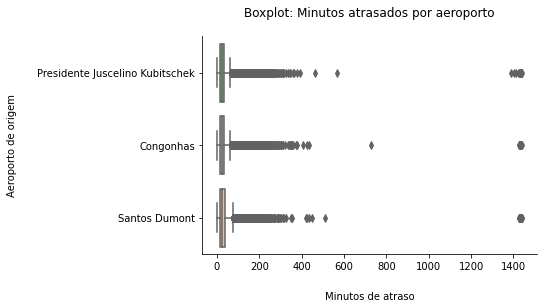

In [46]:
#Detectando outliers atraves de boxplot
sns.boxplot(x='Partida.Atraso', y='Aeroporto.Origem', data=aeroportos_interesse, palette="Accent", order=['Presidente Juscelino Kubitschek','Congonhas','Santos Dumont'])
plt.title('Boxplot: Minutos atrasados por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Minutos de atraso', labelpad=20)
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.show()

In [47]:
#Separando os 3 aeroportos para obter estatisticas individuais
bsb = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Presidente Juscelino Kubitschek']
sdu = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Santos Dumont']
cgh = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Congonhas']

In [48]:
box_stats_bsb = boxplot_stats(bsb['Partida.Atraso'])
box_stats_sdu = boxplot_stats(sdu['Partida.Atraso'])
box_stats_cgh = boxplot_stats(cgh['Partida.Atraso'])

In [49]:
#Mantendo apenas observações dentro de +- 1.5*IQR (critério de outlier de boxplot)
bsb = bsb[bsb['Partida.Atraso'] < box_stats_bsb[0]['q3']+1.5*box_stats_bsb[0]['iqr']]
sdu = sdu[sdu['Partida.Atraso'] < box_stats_sdu[0]['q3']+1.5*box_stats_sdu[0]['iqr']]
cgh = cgh[cgh['Partida.Atraso'] < box_stats_cgh[0]['q3']+1.5*box_stats_cgh[0]['iqr']]

In [50]:
#Novo dataset com sem outliers
aeroportos_interesse = aeroportos_interesse.loc[bsb.index.to_list() + sdu.index.to_list() + cgh.index.to_list()]
aeroportos_interesse.shape

(59195, 30)

In [51]:
#Total de voos atrasados por aeroporto selecionado
aeroportos_interesse['Aeroporto.Origem'].value_counts()

Presidente Juscelino Kubitschek    24399
Congonhas                          21847
Santos Dumont                      12949
Name: Aeroporto.Origem, dtype: int64

In [52]:
#Quantidade de voos atrasados por dia da semana
aeroportos_interesse.groupby('Aeroporto.Origem')['Partida.Prevista.Dia.Semana'].value_counts().unstack()

Partida.Prevista.Dia.Semana,Segunda,Terça,Quarta,Quinta,Sexta,Sábado,Domingo
Aeroporto.Origem,,,,,,,
Congonhas,3641,2831,3353,4104,4699,1430,1789
Presidente Juscelino Kubitschek,3851,3457,3752,4336,4594,2058,2351
Santos Dumont,2412,1579,1821,2301,2650,852,1334


In [53]:
#Quantidade de voos atrasados por aeroporto
aeroportos_interesse.groupby('Aeroporto.Origem')['Companhia.Aerea'].value_counts().unstack()

Companhia.Aerea,AVIANCA,AZUL,GOL,TAM
Aeroporto.Origem,,,,
Congonhas,2833,1265,11830,5919
Presidente Juscelino Kubitschek,3388,1219,8312,11480
Santos Dumont,2193,5295,4738,723


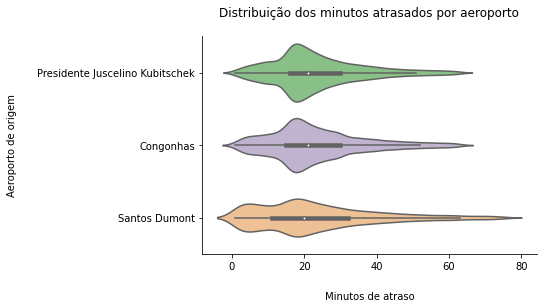

In [54]:
#Distribuição das observações após tratamento para cada aeroporto
sns.violinplot(x='Partida.Atraso', y='Aeroporto.Origem', data=aeroportos_interesse, palette="Accent", order=['Presidente Juscelino Kubitschek','Congonhas','Santos Dumont'])
plt.title('Distribuição dos minutos atrasados por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Minutos de atraso', labelpad=20)
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.show()

In [55]:
aeroportos_interesse = aeroportos_interesse.rename(columns=({'Companhia.Aerea': 'CiaAerea',
                                                             'Codigo.Justificativa': 'Justificativa', 
                                                             'Aeroporto.Destino': 'Destino',
                                                             'Aeroporto.Origem': 'Origem',
                                                             'Partida.Prevista.Dia.Semana':'DiaSemana',
                                                             'Partida.Atraso': 'Atraso'}))

In [56]:
#Começando a análise no aeroporto de brasília Juscelino Kubitschek
voos_bsb = aeroportos_interesse[aeroportos_interesse['Origem'] == 'Presidente Juscelino Kubitschek']

In [57]:
voos_bsb['Atraso'].describe()

count    24399.000000
mean        23.560228
std         12.697627
min          1.000000
25%         16.000000
50%         21.000000
75%         30.000000
max         63.000000
Name: Atraso, dtype: float64

In [58]:
coordenadas_destinos_bsb = pd.DataFrame()
coordenadas_destinos_bsb['Aeroporto'] = voos_bsb['Destino'].unique()
coordenadas_destinos_bsb['Longitude'] = voos_bsb['LongDest'].unique()
coordenadas_destinos_bsb['Latitude'] = voos_bsb['LatDest'].unique()
coordenadas_destinos_bsb = coordenadas_destinos_bsb.set_index('Aeroporto')

In [59]:
voos_por_destino_bsb = pd.DataFrame(data = voos_bsb.groupby('Destino')['Voos'].count())
voos_por_destino_bsb.sort_values(by='Voos', ascending=False).head()

,Voos
Destino,
Santos Dumont,1849
Guarulhos - Governador Andre Franco Montoro,1720
Congonhas,1662
Deputado Luis Eduardo Magalhaes,1220
Tancredo Neves,1098


In [60]:
df_plot_bsb = pd.concat([coordenadas_destinos_bsb,voos_por_destino_bsb], axis=1)
df_plot_bsb['ln(Qtd_voos)'] = np.log(df_plot_bsb['Voos'])
df_plot_bsb.sort_values(by='Voos', inplace=True)

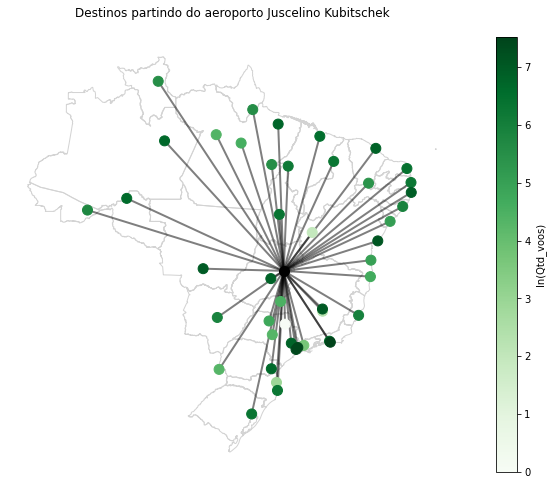

In [61]:
fig,ax = plt.subplots(figsize=(14,8))
mapa_brasil.plot(ax=ax, fc='None', ec='lightgray')
for i in df_plot_bsb.index:
  ax.plot([voos_bsb['LongOrig'].unique(),df_plot_bsb['Longitude'][i]],
          [voos_bsb['LatOrig'].unique(),df_plot_bsb['Latitude'][i]],
          color='black', lw=2, alpha=0.5, zorder=1)
ax.scatter(voos_bsb['LongOrig'].unique(), voos_bsb['LatOrig'].unique(), c='Black', zorder=2, s=100)
df_plot_bsb.plot(x='Longitude', y='Latitude', kind='scatter', s=100, ax=ax, zorder=2, c='ln(Qtd_voos)', cmap='Greens')
plt.title('Destinos partindo do aeroporto Juscelino Kubitschek', pad=20, fontsize=12, color='black')
sns.despine(bottom=True, left=True)
plt.ylabel(None)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel(None)
plt.show()

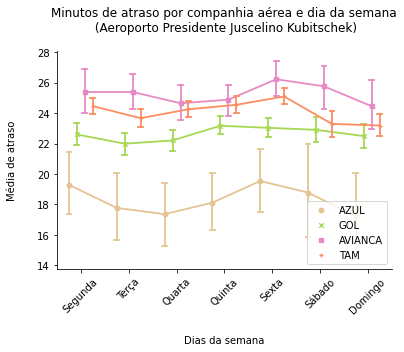

In [62]:
#Média de atraso por dia da semana e por companhia aerea com intervalo de confiança de 95%
sns.set_context(rc = {'lines.linewidth': 1})
sns.pointplot(x='DiaSemana', y='Atraso', data=voos_bsb, hue='CiaAerea', palette='Set2_r',
              ci=95, capsize=.1, markers=["o", "x", "s", "+"], dodge=0.5)
plt.title('Minutos de atraso por companhia aérea e dia da semana\n (Aeroporto Presidente Juscelino Kubitschek)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dias da semana', labelpad=20)
plt.ylabel('Média de atraso', labelpad=20)
plt.legend()
plt.show()

In [63]:
#2 way anova
model_bsb = ols('Atraso ~ C(DiaSemana) + C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_bsb).fit()
sm.stats.anova_lm(model_bsb, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),5.177050e+03,6.0,5.433163,1.262926e-05
C(CiaAerea),5.560764e+04,3.0,116.717203,4.773108e-75
C(DiaSemana):C(CiaAerea),2.719580e+03,18.0,0.951373,5.145734e-01
Residual,3.870363e+06,24371.0,NaN,NaN


In [64]:
#Como a interação DiaSemana:CiaAerea deu não significativa, rodamos novamente o modelo reduzido
model_bsb = ols('Atraso ~ C(DiaSemana) + C(CiaAerea)', voos_bsb).fit()
sm.stats.anova_lm(model_bsb, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),5.177050e+03,6.0,5.433358,1.262266e-05
C(CiaAerea),5.560764e+04,3.0,116.721392,4.739422e-75
Residual,3.873082e+06,24389.0,NaN,NaN


In [65]:
#Diferença entre os pares de dia da semana (reject == True significa que tem diferença)
mc_dia_da_semana_bsb = sm.stats.multicomp.MultiComparison(voos_bsb['Atraso'], voos_bsb['DiaSemana']).tukeyhsd()
print(mc_dia_da_semana_bsb)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Domingo  Quarta   0.4881 0.7397 -0.4962  1.4724  False
Domingo  Quinta   0.9703  0.045  0.0119  1.9287   True
Domingo Segunda   0.8771 0.1142 -0.1023  1.8565  False
Domingo   Sexta   1.4703  0.001  0.5214  2.4192   True
Domingo  Sábado   0.6236 0.6423  -0.506  1.7532  False
Domingo   Terça    0.292    0.9 -0.7084  1.2923  False
 Quarta  Quinta   0.4822 0.5975 -0.3522  1.3165  False
 Quarta Segunda    0.389 0.8137 -0.4694  1.2474  False
 Quarta   Sexta   0.9823  0.008  0.1588  1.8057   True
 Quarta  Sábado   0.1355    0.9 -0.8909   1.162  False
 Quarta   Terça  -0.1961    0.9 -1.0783  0.6861  False
 Quinta Segunda  -0.0932    0.9 -0.9217  0.7354  False
 Quinta   Sexta   0.5001 0.5052 -0.2922  1.2924  False
 Quinta  Sábado  -0.3466    0.9 -1.3483   0.655  False
 Quinta   Terça  -0.6783 0.2231 -1.5315  0.1749  False
Segunda   

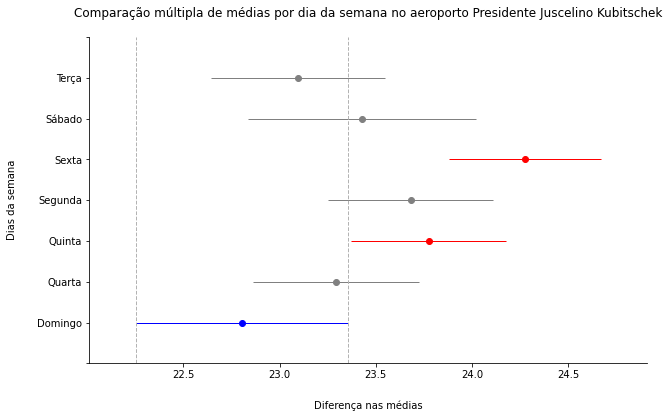

In [66]:
#A melhor média encontra-se destacada das demais
mc_dia_da_semana_bsb.plot_simultaneous(comparison_name = 'Domingo')
plt.title('Comparação múltipla de médias por dia da semana no aeroporto Presidente Juscelino Kubitschek', pad=20)
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Dias da semana', labelpad=20)
# plt.yticks(ticks=np.arange(7), labels=dias_da_semana_pt)
plt.show()

In [67]:
#Diferença entre os pares de Cia Aérea (reject == True tem diferença significativa)
mc_cia_aerea_bsb = sm.stats.multicomp.MultiComparison(voos_bsb['Atraso'], voos_bsb['CiaAerea']).tukeyhsd()
print(mc_cia_aerea_bsb)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
AVIANCA   AZUL  -6.9533 0.001 -8.0352 -5.8713   True
AVIANCA    GOL  -2.6297 0.001   -3.29 -1.9695   True
AVIANCA    TAM  -1.0506 0.001  -1.684 -0.4172   True
   AZUL    GOL   4.3235 0.001    3.33  5.3171   True
   AZUL    TAM   5.9027 0.001  4.9268  6.8785   True
    GOL    TAM   1.5791 0.001  1.1126  2.0457   True
----------------------------------------------------


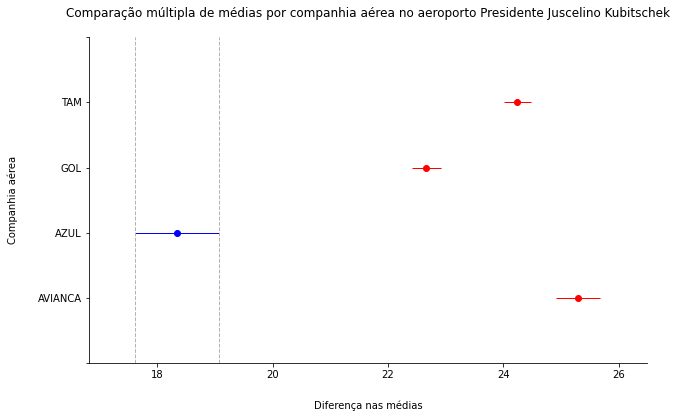

In [68]:
#A melhor média encontra-se destacada das demais
mc_cia_aerea_bsb.plot_simultaneous(comparison_name = 'AZUL')
plt.title('Comparação múltipla de médias por companhia aérea no aeroporto Presidente Juscelino Kubitschek', pad=20)
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Companhia aérea', labelpad=20)
plt.show()

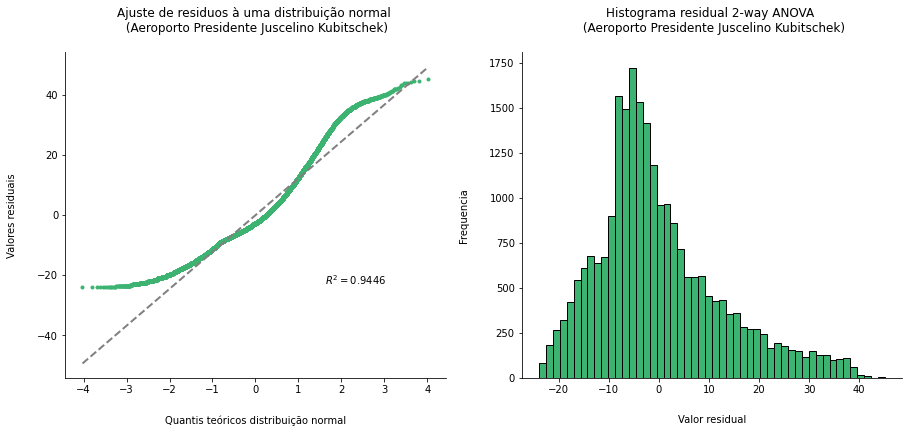

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
stats.probplot(model_bsb.resid, plot=ax1, rvalue=True)
ax1.set_title('Ajuste de residuos à uma distribuição normal \n (Aeroporto Presidente Juscelino Kubitschek)', pad=20)
ax1.get_lines()[0].set_markerfacecolor('mediumseagreen')
ax1.get_lines()[0].set_markeredgecolor('mediumseagreen')
ax1.get_lines()[0].set_markersize(3)
ax1.get_lines()[1].set_linewidth(2)
ax1.get_lines()[1].set_linestyle('--')
ax1.get_lines()[1].set_color('gray')
ax1.set_xlabel('Quantis teóricos distribuição normal', labelpad=20)
ax1.set_ylabel('Valores residuais', labelpad=20)

ax2.hist(model_bsb.resid, ec='black', fc='mediumseagreen',bins=50)
ax2.set_title('Histograma residual 2-way ANOVA \n (Aeroporto Presidente Juscelino Kubitschek)', pad=20)
ax2.set_xlabel('Valor residual', labelpad=20)
ax2.set_ylabel('Frequencia', labelpad=20)

sns.despine()
plt.show()

In [70]:
#Começando a análise do aeroporto carioca Santos Dumont
voos_sdu = aeroportos_interesse[aeroportos_interesse['Origem'] == 'Santos Dumont']

In [71]:
voos_sdu['Atraso'].describe()

count    12949.000000
mean        23.606611
std         16.747383
min          1.000000
25%         11.000000
50%         20.000000
75%         32.000000
max         75.000000
Name: Atraso, dtype: float64

In [72]:
coordenadas_destinos_sdu = pd.DataFrame()
coordenadas_destinos_sdu['Aeroporto'] = voos_sdu['Destino'].unique()
coordenadas_destinos_sdu['Longitude'] = voos_sdu['LongDest'].unique()
coordenadas_destinos_sdu['Latitude'] = voos_sdu['LatDest'].unique()
coordenadas_destinos_sdu = coordenadas_destinos_sdu.set_index('Aeroporto')

In [73]:
voos_por_destino_sdu = pd.DataFrame(data = voos_sdu.groupby(['Destino'])['Voos'].count())
voos_por_destino_sdu.sort_values(by='Voos', ascending=False).head()

,Voos
Destino,
Congonhas,3592
Viracopos,1924
Guarulhos - Governador Andre Franco Montoro,1684
Presidente Juscelino Kubitschek,1461
Tancredo Neves,1396


In [74]:
df_plot_sdu = pd.concat([coordenadas_destinos_sdu,voos_por_destino_sdu], axis=1)
df_plot_sdu['ln(Qtd_voos)'] = np.log(df_plot_sdu['Voos'])
df_plot_sdu.sort_values(by='Voos', inplace=True)

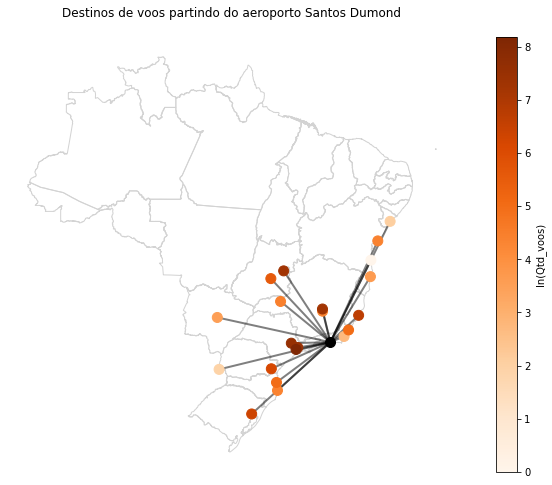

In [75]:
fig,ax = plt.subplots(figsize=(14,8))
mapa_brasil.plot(ax=ax, fc='None', ec='lightgray')
for i in df_plot_sdu.index:
  ax.plot([voos_sdu['LongOrig'].unique(),df_plot_sdu['Longitude'][i]],
          [voos_sdu['LatOrig'].unique(),df_plot_sdu['Latitude'][i]],
          color='black', lw=2, alpha=0.5, zorder=1)
ax.scatter(voos_sdu['LongOrig'].unique(), voos_sdu['LatOrig'].unique(), c='Black', zorder=2, s=100)
df_plot_sdu.plot(x='Longitude', y='Latitude', kind='scatter', s=100, ax=ax, zorder=2, c='ln(Qtd_voos)', cmap='Oranges')
plt.title('Destinos de voos partindo do aeroporto Santos Dumond', pad=20)
sns.despine(bottom=True, left=True)
plt.ylabel(None)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel(None)
plt.show()

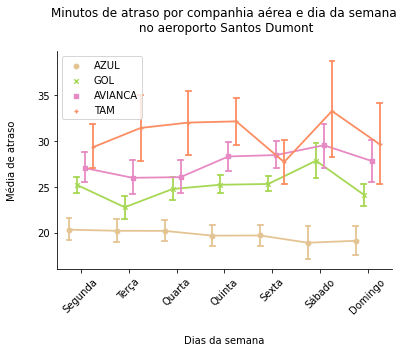

In [76]:
#Média de atraso por dia da semana e por companhia aerea com intervalo de confiança de 95%
sns.set_context(rc = {'lines.linewidth': 1})
sns.pointplot(x='DiaSemana', y='Atraso', data=voos_sdu, hue='CiaAerea', palette='Set2_r',
              ci=95, capsize=.1, markers=["o", "x", "s", "+"], dodge=0.5, order=dias_da_semana_pt)
plt.title('Minutos de atraso por companhia aérea e dia da semana\n no aeroporto Santos Dumont', pad=20)
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dias da semana', labelpad=20)
plt.ylabel('Média de atraso', labelpad=20)
plt.legend()
plt.show()

In [77]:
#2 way anova
model_sdu = ols('Atraso ~ C(DiaSemana) + C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_sdu).fit()
sm.stats.anova_lm(model_sdu, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),2.427460e+03,6.0,1.507016,1.713225e-01
C(CiaAerea),1.495727e+05,3.0,185.715484,6.598802e-118
C(DiaSemana):C(CiaAerea),8.910203e+03,18.0,1.843877,1.592695e-02
Residual,3.468799e+06,12921.0,NaN,NaN


In [78]:
#Dia da semana não é significativo no atraso, então rodamos o modelo reduzido
model_sdu = ols('Atraso ~ C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_sdu).fit()
sm.stats.anova_lm(model_sdu, typ=2)

,sum_sq,df,F,PR(>F)
C(CiaAerea),1.514512e+05,3.0,188.047864,2.321825e-119
C(DiaSemana):C(CiaAerea),1.133766e+04,24.0,1.759662,1.225849e-02
Residual,3.468799e+06,12921.0,NaN,NaN


In [79]:
#Diferenca entre os pares de Cia Aerea (reject == True tem diferença significativa)
mc_cia_aerea_sdu = sm.stats.multicomp.MultiComparison(voos_sdu['Atraso'], voos_sdu['CiaAerea']).tukeyhsd()
print(mc_cia_aerea_sdu)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
AVIANCA   AZUL  -7.7058 0.001 -8.7756  -6.636   True
AVIANCA    GOL  -2.5661 0.001 -3.6541  -1.478   True
AVIANCA    TAM   2.8543 0.001  1.0476  4.6609   True
   AZUL    GOL   5.1397 0.001  4.2973  5.9822   True
   AZUL    TAM  10.5601 0.001  8.8898 12.2304   True
    GOL    TAM   5.4203 0.001  3.7383  7.1024   True
----------------------------------------------------


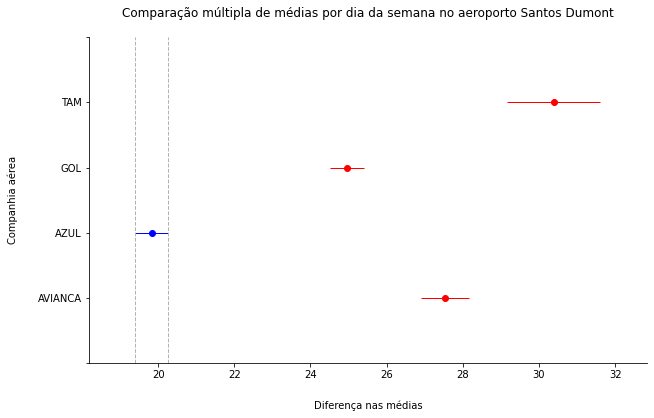

In [80]:
#A melhor média encontra-se destacada das demais
mc_cia_aerea_sdu.plot_simultaneous(comparison_name = 'AZUL')
plt.title('Comparação múltipla de médias por dia da semana no aeroporto Santos Dumont', pad=20)
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Companhia aérea', labelpad=20)
plt.show()

In [81]:
##Diferenca entre os pares de interação DiaSemana + CiaAerea (reject == True tem diferença significativa)
interaction_groups_sdu = voos_sdu['CiaAerea'] + ' & ' + voos_sdu['DiaSemana'].astype('object')
mc_interacao_cia_aerea_dia_da_semana_sdu = sm.stats.multicomp.MultiComparison(voos_sdu['Atraso'], interaction_groups_sdu).tukeyhsd()
print(mc_interacao_cia_aerea_dia_da_semana_sdu)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------
AVIANCA & Domingo  AVIANCA & Quarta  -1.7592    0.9  -7.2524  3.7341  False
AVIANCA & Domingo  AVIANCA & Quinta    0.499    0.9  -4.9005  5.8986  False
AVIANCA & Domingo AVIANCA & Segunda  -0.7706    0.9  -6.2696  4.7284  False
AVIANCA & Domingo   AVIANCA & Sexta    0.653    0.9  -4.5789  5.8849  False
AVIANCA & Domingo  AVIANCA & Sábado   1.7248    0.9  -4.6082  8.0577  False
AVIANCA & Domingo   AVIANCA & Terça  -1.8321    0.9  -7.4972  3.8331  False
AVIANCA & Domingo    AZUL & Domingo  -8.7094  0.001 -13.8614 -3.5574   True
AVIANCA & Domingo     AZUL & Quarta  -7.6271  0.001 -12.5098 -2.7444   True
AVIANCA & Domingo     AZUL & Quinta  -8.1496  0.001 -12.9971 -3.3022   True
AVIANCA & Domingo    AZUL & Segunda  -7.4976  0.001  -12.328 -2.6672   True
AVIANCA & Do

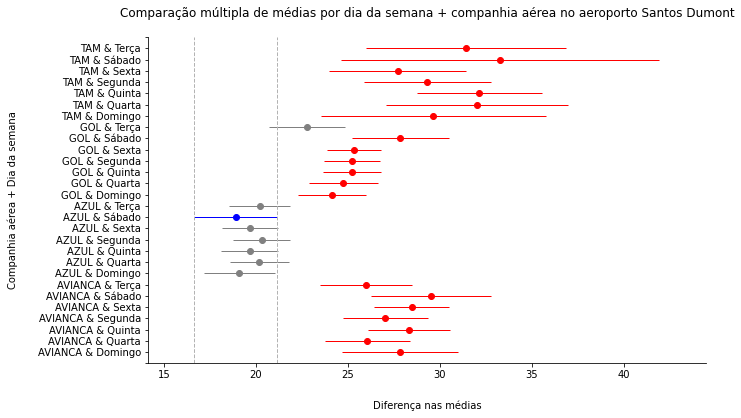

In [82]:
#A melhor média encontra-se destacada das demais
mc_interacao_cia_aerea_dia_da_semana_sdu.plot_simultaneous(comparison_name='AZUL & Sábado')
plt.title('Comparação múltipla de médias por dia da semana + companhia aérea no aeroporto Santos Dumont', pad=20)
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Companhia aérea + Dia da semana', labelpad=20)
plt.show()

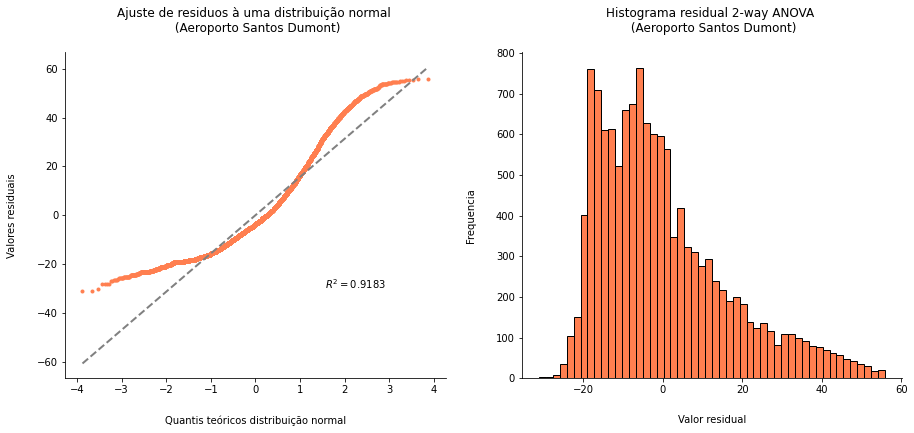

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
stats.probplot(model_sdu.resid, plot=ax1, rvalue=True)
ax1.set_title('Ajuste de residuos à uma distribuição normal \n (Aeroporto Santos Dumont)', pad=20)
ax1.get_lines()[0].set_markerfacecolor('coral')
ax1.get_lines()[0].set_markeredgecolor('coral')
ax1.get_lines()[0].set_markersize(3)
ax1.get_lines()[1].set_linewidth(2)
ax1.get_lines()[1].set_linestyle('--')
ax1.get_lines()[1].set_color('gray')
ax1.set_xlabel('Quantis teóricos distribuição normal', labelpad=20)
ax1.set_ylabel('Valores residuais', labelpad=20)

ax2.hist(model_sdu.resid, ec='black', fc='coral',bins=50)
ax2.set_title('Histograma residual 2-way ANOVA \n (Aeroporto Santos Dumont)', pad=20)
ax2.set_xlabel('Valor residual', labelpad=20)
ax2.set_ylabel('Frequencia', labelpad=20)

sns.despine()
plt.show()

In [84]:
#Começando a análise do aeroporto carioca Santos Dumont
voos_cgh = aeroportos_interesse[aeroportos_interesse['Origem'] == 'Congonhas']

In [85]:
voos_cgh['Atraso'].describe()

count    21847.000000
mean        23.474390
std         13.188194
min          1.000000
25%         15.000000
50%         21.000000
75%         30.000000
max         63.000000
Name: Atraso, dtype: float64

In [86]:
coordenadas_destinos_cgh = pd.DataFrame()
coordenadas_destinos_cgh['Aeroporto'] = voos_cgh['Destino'].unique()
coordenadas_destinos_cgh['Longitude'] = voos_cgh['LongDest'].unique()
coordenadas_destinos_cgh['Latitude'] = voos_cgh['LatDest'].unique()
coordenadas_destinos_cgh = coordenadas_destinos_cgh.set_index('Aeroporto')

In [87]:
voos_por_destino_cgh = pd.DataFrame(data = voos_cgh.groupby(['Destino'])['Voos'].count())
voos_por_destino_cgh.sort_values(by='Voos', ascending=False).head()

,Voos
Destino,
Santos Dumont,3591
Salgado Filho,2133
Presidente Juscelino Kubitschek,2091
Tancredo Neves,1832
Afonso Pena,1333


In [88]:
df_plot_cgh = pd.concat([coordenadas_destinos_cgh,voos_por_destino_cgh], axis=1)
df_plot_cgh['ln(Qtd_voos)'] = np.log(df_plot_cgh['Voos'])
df_plot_cgh.sort_values(by='Voos', inplace=True)

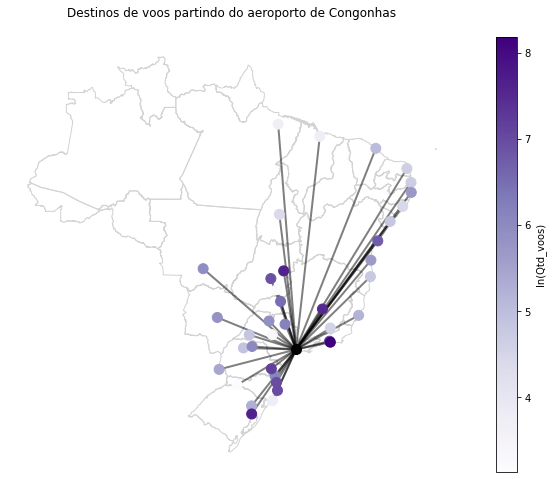

In [89]:
fig,ax = plt.subplots(figsize=(14,8))
mapa_brasil.plot(ax=ax, fc='None', ec='lightgray')
for i in df_plot_cgh.index:
  ax.plot([voos_cgh['LongOrig'].unique(),df_plot_cgh['Longitude'][i]],
          [voos_cgh['LatOrig'].unique(),df_plot_cgh['Latitude'][i]],
          color='black', lw=2, alpha=0.5, zorder=1)
ax.scatter(voos_cgh['LongOrig'].unique(), voos_cgh['LatOrig'].unique(), c='Black', zorder=2, s=100)
df_plot_cgh.plot(x='Longitude', y='Latitude', kind='scatter', s=100, lw=1, ax=ax, zorder=2, c='ln(Qtd_voos)', cmap='Purples')
plt.title('Destinos de voos partindo do aeroporto de Congonhas', pad=20)
sns.despine(bottom=True, left=True)
plt.ylabel(None)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel(None)
plt.show()

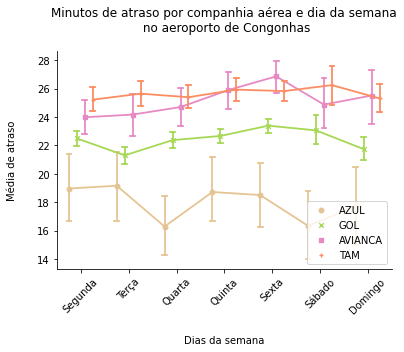

In [90]:
#Média de atraso por dia da semana e por companhia aerea com intervalo de confiança de 95%
sns.set_context(rc = {'lines.linewidth': 1})
sns.pointplot(x='DiaSemana', y='Atraso', data=voos_cgh, hue='CiaAerea', palette='Set2_r', title='Atraso por CiaAerea e DiaSemana',
              ci=95, capsize=.1, markers=["o", "x", "s", "+"], dodge=0.5, order=dias_da_semana_pt)
plt.title('Minutos de atraso por companhia aérea e dia da semana\n no aeroporto de Congonhas', pad=20)
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dias da semana', labelpad=20)
plt.ylabel('Média de atraso', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [91]:
#2 way anova
model_cgh = ols('Atraso ~ C(DiaSemana) + C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_cgh).fit()
sm.stats.anova_lm(model_cgh, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),5.456521e+03,6.0,5.357067,1.546404e-05
C(CiaAerea),8.558674e+04,3.0,168.053573,1.041581e-107
C(DiaSemana):C(CiaAerea),4.834636e+03,18.0,1.582172,5.524041e-02
Residual,3.704012e+06,21819.0,NaN,NaN


In [92]:
#Diferenca entre os pares de DiaSemana (reject == True tem diferença significativa)
mc_dia_da_semana_cgh = sm.stats.multicomp.MultiComparison(voos_cgh['Atraso'], voos_cgh['DiaSemana']).tukeyhsd()
print(mc_dia_da_semana_cgh)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Domingo  Quarta  -0.2886    0.9 -1.4265  0.8493  False
Domingo  Quinta   0.2923    0.9 -0.8088  1.3933  False
Domingo Segunda  -0.2551    0.9 -1.3772  0.8671  False
Domingo   Sexta   0.7929 0.3146 -0.2868  1.8726  False
Domingo  Sábado   0.0755    0.9 -1.3032  1.4541  False
Domingo   Terça  -0.7124 0.5472 -1.8863  0.4614  False
 Quarta  Quinta   0.5809 0.4855 -0.3238  1.4856  False
 Quarta Segunda   0.0336    0.9 -0.8967  0.9638  False
 Quarta   Sexta   1.0815 0.0053  0.2029  1.9601   True
 Quarta  Sábado   0.3641    0.9 -0.8634  1.5916  False
 Quarta   Terça  -0.4238 0.8588 -1.4158  0.5682  False
 Quinta Segunda  -0.5473 0.5271 -1.4321  0.3375  False
 Quinta   Sexta   0.5006 0.5542 -0.3298   1.331  False
 Quinta  Sábado  -0.2168    0.9 -1.4103  0.9767  False
 Quinta   Terça  -1.0047   0.03 -1.9542 -0.0552   True
Segunda   

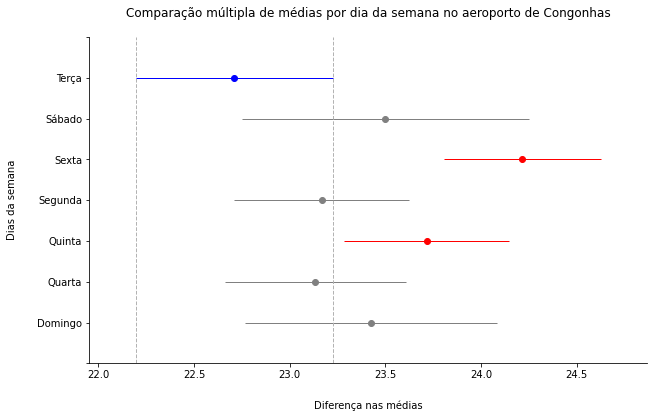

In [93]:
#A melhor média encontra-se destacada das demais
mc_dia_da_semana_cgh.plot_simultaneous(comparison_name='Terça')
plt.title('Comparação múltipla de médias por dia da semana no aeroporto de Congonhas', pad=20)
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Dias da semana', labelpad=20)
plt.show()

In [94]:
#Diferenca entre os pares de Cia Aerea (reject == True tem diferença significativa)
mc_cia_aerea_cgh = sm.stats.multicomp.MultiComparison(voos_cgh['Atraso'], voos_cgh['CiaAerea']).tukeyhsd()
print(mc_cia_aerea_cgh)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
AVIANCA   AZUL  -7.3003  0.001 -8.4332 -6.1674   True
AVIANCA    GOL   -2.731  0.001 -3.4318 -2.0302   True
AVIANCA    TAM   0.3608 0.6054 -0.4046  1.1262  False
   AZUL    GOL   4.5693  0.001  3.5782  5.5604   True
   AZUL    TAM   7.6611  0.001  6.6233  8.6989   True
    GOL    TAM   3.0918  0.001  2.5584  3.6252   True
-----------------------------------------------------


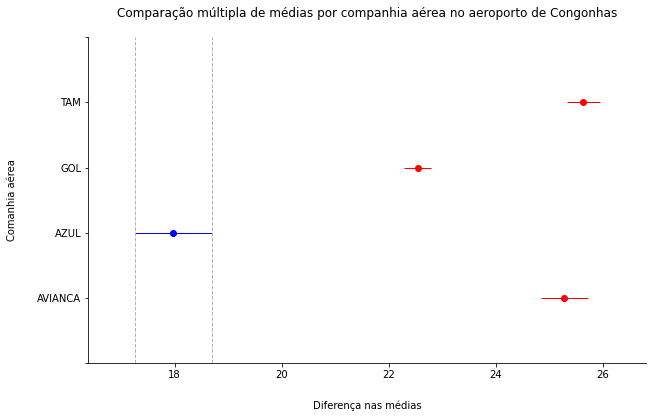

In [95]:
#A melhor média encontra-se destacada das demais
mc_cia_aerea_cgh.plot_simultaneous(comparison_name='AZUL')
plt.title('Comparação múltipla de médias por companhia aérea no aeroporto de Congonhas', pad=20)
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Comanhia aérea', labelpad=20)
plt.show()

In [96]:
#Diferenca entre os pares de interação Dia Semana + Cia Aerea (reject == True tem diferença significativa)
interaction_groups_cgh = voos_cgh['CiaAerea'] + ' & ' + voos_cgh['DiaSemana'].astype('object')
mc_interacao_cia_aerea_dia_da_semana_cgh = sm.stats.multicomp.MultiComparison(voos_cgh['Atraso'], interaction_groups_cgh).tukeyhsd()
print(mc_interacao_cia_aerea_dia_da_semana_cgh)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------
AVIANCA & Domingo  AVIANCA & Quarta  -0.8158    0.9  -4.4907  2.8592  False
AVIANCA & Domingo  AVIANCA & Quinta   0.3836    0.9  -3.2293  3.9965  False
AVIANCA & Domingo AVIANCA & Segunda  -1.5347    0.9   -5.218  2.1485  False
AVIANCA & Domingo   AVIANCA & Sexta   1.3491    0.9  -2.1434  4.8416  False
AVIANCA & Domingo  AVIANCA & Sábado    -0.64    0.9  -4.8221  3.5421  False
AVIANCA & Domingo   AVIANCA & Terça  -1.3443    0.9  -5.2002  2.5115  False
AVIANCA & Domingo    AZUL & Domingo   -7.803  0.001 -13.1151  -2.491   True
AVIANCA & Domingo     AZUL & Quarta  -9.2381  0.001 -13.6677 -4.8084   True
AVIANCA & Domingo     AZUL & Quinta  -6.8039  0.001 -11.2335 -2.3743   True
AVIANCA & Domingo    AZUL & Segunda  -6.5594  0.001 -11.1492 -1.9697   True
AVIANCA & Do

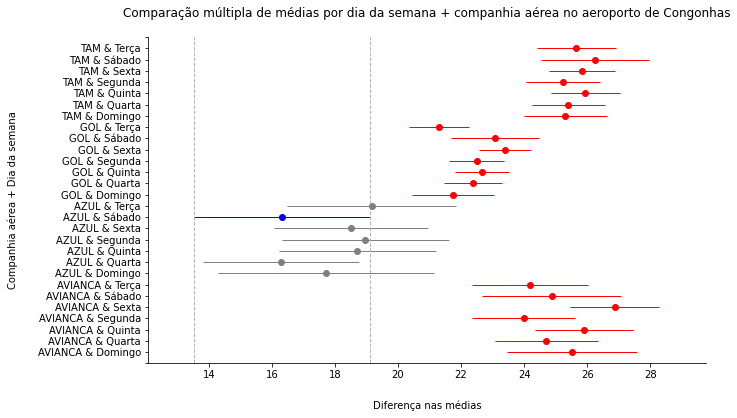

In [97]:
#A melhor média encontra-se destacada das demais
mc_interacao_cia_aerea_dia_da_semana_cgh.plot_simultaneous(comparison_name='AZUL & Sábado')
plt.title('Comparação múltipla de médias por dia da semana + companhia aérea no aeroporto de Congonhas', pad=20)
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Companhia aérea + Dia da semana', labelpad=20)
plt.show()

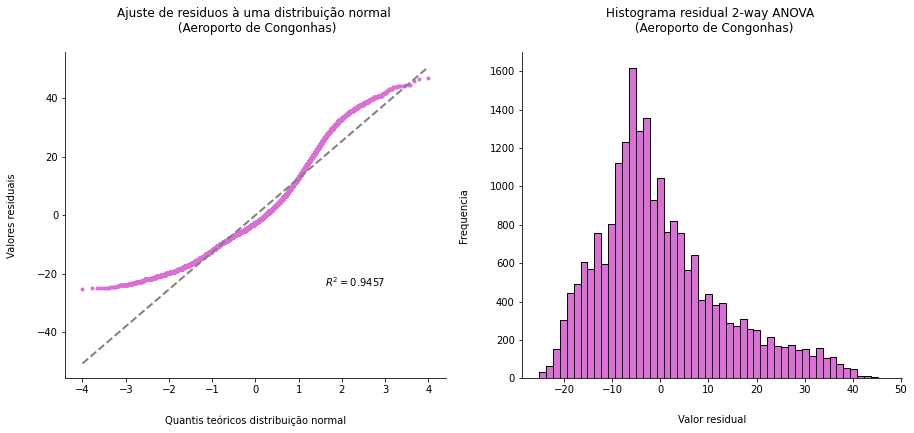

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
stats.probplot(model_cgh.resid, plot=ax1, rvalue=True)
ax1.set_title('Ajuste de residuos à uma distribuição normal \n (Aeroporto de Congonhas)', pad=20)
ax1.get_lines()[0].set_markerfacecolor('orchid')
ax1.get_lines()[0].set_markeredgecolor('orchid')
ax1.get_lines()[0].set_markersize(3)
ax1.get_lines()[1].set_linewidth(2)
ax1.get_lines()[1].set_linestyle('--')
ax1.get_lines()[1].set_color('gray')
ax1.set_xlabel('Quantis teóricos distribuição normal', labelpad=20)
ax1.set_ylabel('Valores residuais', labelpad=20)

ax2.hist(model_cgh.resid, ec='black', fc='orchid',bins=50)
ax2.set_title('Histograma residual 2-way ANOVA \n (Aeroporto de Congonhas)', pad=20)
ax2.set_xlabel('Valor residual', labelpad=20)
ax2.set_ylabel('Frequencia', labelpad=20)

sns.despine()
plt.show()